# **Thursdays Brown Bag Meeting**: Introduction to NLP


---

In this session we will:
1. Walkthrough the mathematical foundation of NLP-based Machine Learning
2. Understand better the fields of application, and the differences between NLP / NLU
3. A practical exercise on sentiment prediction

---

In [1]:
import pandas as pd
from gensim.corpora import Dictionary
import spacy
from gensim.models import TfidfModel
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
import gensim.models as g
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)


## 1. Motivation and relevant use cases


### 1.1. Motivation and challenges

- Natural Language Processing or **NLP is "*a field of artificial intelligence that gives the machines the ability to read, understand and derive meaning from human languages*"**
<br>

- **Language carries information that humans can naturally unpack**. We take for granted the complexity inherent to language, resulting from elongated periods of evolution, most of the times bypassing languague amibiguities:
<br>

    - Example 1: *"John kissed his wife, and so did Sam"*
    <br>
    - Example 2: The buffalo sentence [buffalo sentence](https://en.wikipedia.org/wiki/Buffalo_buffalo_Buffalo_buffalo_buffalo_buffalo_Buffalo_buffalo)

![Buffalo](images/buffalo.PNG)


- From a conceptual perspective and under the assumption that we can disambiguate the language, **text is virtually the most complete source of information**. Where do we find important applications?
---

### 1.2. Relevant use cases

Several use cases have been identified across the industry for the use of natural language as a source of data for prediction purposes. Some [notable ones](https://medium.com/@ODSC/an-introduction-to-natural-language-processing-nlp-8e476d9f5f59):

- **Detection of spam email**: Probably the first succesful application of NLP in the industry
- **Recognition and prediction of diseases**: Using information such as health records or patient's own speech, conditions such as cardiovascular diseases or schizophrenia can be potentially diagnosed, with [specific services](https://aws.amazon.com/comprehend/medical/) around this topic (*)
- **Brand sentiment and customer satisfaction**: Social media data can be used for sentiment analysis, understanding the degree of customer satisfaction, brand perception and main improvement areas for businesses
- **Recommendation systems and personal assistants**: Amazon Alexa's and Google's Nest are two powerful examples.
- **Identification of fake news**: the NLP Group at MIT developed a new system to determine if a source is accurate or politically biased, detecting if a news source can be trusted or not

Or eveeeen...

- **Detection of controversies from raw text powering Clarity controversy scores!**
---
---

## 2. Mathematical foundation and feature generation

We know how to attempt the prediction of numbers with numbers (regression, classification). But, **how do we attempt the prediction of numbers with text?**
<br><br>
In this case the simplest answer is the right one: **convert text into numbers!**. Let's start with the simple exercise below:

![sentence](images/sentence.PNG)


In [2]:
sentence = nlp('The big cat is drinking milk')
sentence

The big cat is drinking milk

Pretrained English model from gensim lets us identify the elements in the sentence

In [3]:
print('Our tokenized sentence:', [token for token in sentence])
print('\nSyntactic analysis:', [token.pos_ for token in sentence])

Our tokenized sentence: [The, big, cat, is, drinking, milk]

Syntactic analysis: ['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'NOUN']


### 2.1. First approach: Bag of Word counts

We can extract features by simply counting the number of appearances of each word in our vocabulary in the studied sentence. 

In [4]:
# Your corpus (set of texts) will define your vocabulary
universe_of_sentences = ["The small cat will never drink milk, and it only eats its catnip",
                         'The dog only eats soft food, and it loves drinking cold water water',
                         'The big cat loves raw meat and drinks very little water in the day',
                         'The animals in the farm are fed all the same, including what they drink',
                         "A cow is pacing grass, which has enough water on it so it doesn't really drink during the day",
                         'The ducklings are being fed by the mom',
                         
                         'The knight is battling in the battlefield, wearing its shinny armor',
                         'The castle is being sieged and the enemies will not stop until conquering it',
                         'The empire is being attacked by the barbarians',
                         'The blacksmith is forging axes for the incoming battle']

# Create the vocabulary object and obtain the bag of word representation
dct = Dictionary([x.split() for x in universe_of_sentences])
record = {dct[k]: 0 for k,v in dct.items()}
record.update({dct[k]: v for k,v in dct.doc2bow(universe_of_sentences[0].split())})
pd.DataFrame([record])


,The,and,cat,catnip,drink,eats,it,its,"milk,",never,only,small,will,cold,dog,drinking,"food,",loves,soft,water,big,day,drinks,in,little,meat,raw,the,very,all,animals,are,farm,fed,including,"same,",they,what,A,cow,doesn't,during,enough,"grass,",has,is,on,pacing,really,so,which,being,by,ducklings,mom,armor,"battlefield,",battling,knight,shinny,wearing,castle,conquering,enemies,not,sieged,stop,until,attacked,barbarians,empire,axes,battle,blacksmith,for,forging,incoming
0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Conceptually, the above is sufficient to provide a mathematical representation of our sentence, where we have variables (each word) based on which we could try and predict something.

However, several issues arise:
- Variable values would increase for longer texts, so we could consider normalizing to the total length of the text
- Several words provide no real meaning in the context of a word count. For example, the word "the" is common across any type of sentence and we cannot expect it to provide valuable information. This is what we call **stop words**, which should be removed  as a part of the **tokenization** process
- Several words present similar forms, all with the same lemma. For simplicity and generalization, we should either apply [**lematization** / **stemming**](https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8).

### 2.2. Second approach, TF-IDF scores

Around the concept of bag of words, we can build **more powerful mathematical artifacts**. These include among others [TF-IDF scores](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). These scores provide a view of how relevant a word is in a document in relation to its relevancy across the corpus, increasing proportionally to the number of times a word appears in the document and offset by the number of documents in the corpus that contain the word.

In [5]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Some example stopwords:', list(stopwords)[20:25])

# Modify the universe of sentences by removing stopwords and lemmatizing
universe_of_sentences_mod = [[token.lemma_.lower() for token in nlp(sentence) 
                              if token not in stopwords] 
                             for sentence in universe_of_sentences]

print('\n3rd sentence, transformed:', universe_of_sentences_mod[3])

# Train the TFIDF model over our corpus
TFIDF_model = TfidfModel([dct.doc2bow(sentence) for sentence in universe_of_sentences_mod])

# Get the representation for the first sentence in the universe
record = {dct[k]: 0 for k,v in dct.items()}
record.update({dct[k]:v for k,v in TFIDF_model[dct.doc2bow(universe_of_sentences_mod[0])]})
pd.DataFrame([record])



Some example stopwords: ['say', 'next', 'take', 'eight', 'thereafter']

3rd sentence, transformed: ['the', 'animal', 'in', 'the', 'farm', 'be', 'feed', 'all', 'the', 'same', ',', 'include', 'what', '-pron-', 'drink']


,The,and,cat,catnip,drink,eats,it,its,"milk,",never,only,small,will,cold,dog,drinking,"food,",loves,soft,water,big,day,drinks,in,little,meat,raw,the,very,all,animals,are,farm,fed,including,"same,",they,what,A,cow,doesn't,during,enough,"grass,",has,is,on,pacing,really,so,which,being,by,ducklings,mom,armor,"battlefield,",battling,knight,shinny,wearing,castle,conquering,enemies,not,sieged,stop,until,attacked,barbarians,empire,axes,battle,blacksmith,for,forging,incoming
0,0,0.183271,0.321909,0.460548,0.138639,0,0,0,0,0.460548,0.321909,0.460548,0.321909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


While we now have a more powerful representation of the sentence, **we are still facing the main issue in bag of words approaches: we have eliminated the syntactical representation provided by the sentence.** In this context *"the door is behing the table"* and *"the table is behind the door"* would have **the same** representation.

### 2.3. Introduction to document embeddings

More advance approaches start making use of **language models** that learn **representation of the words / sentences in alternative feature spaces**, capturing relevant text features.

Some of the most relevant **word representations are**:
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

Famously, Word2Vec embeddings are depicted as presenting the same ("*king*" - *"queen"*) vector distance as the ("*man*" - *"woman"*) vector distance, which illustrates the ability of the algorithm of representing words in relevant syntactical spaces.
<br>

![sentence](images/king_queen.PNG)

<br><br>
As an extension of word representations we find **sentence representations**, such as Doc2Vec.

### 2.4. Third approach, document embeddings

Doc2Vec enables a vector representation in an n-dimensional space, where angular proximity between vectors is associated with syntactical similarity (refer [here](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) for a gentle introduction)


In [6]:
# aws s3 cp s3://clarity-data-science-team/controversies/pretrained_doc2vec/AssociatedPressNews/doc2vec.bin.syn1neg.npy ./

In [7]:
# Load pretrained wikipedia-trained Doc2Vec model
pd.options.display.max_colwidth = 100
Doc2Vec_model = g.Doc2Vec.load('doc2vec/doc2vec.bin')

# Get the vector representation of our sentences
embeddings = pd.DataFrame([Doc2Vec_model.infer_vector(sentence.split(), alpha=0.05, steps=1) for sentence in universe_of_sentences], 
                          columns=['Doc2Vec_{}'.format(x) for x in range(300)])
embeddings['sentence'] = universe_of_sentences
embeddings = embeddings[['sentence']+list(embeddings.columns[:-1])]
embeddings.loc[0]


sentence       The small cat will never drink milk, and it only eats its catnip
Doc2Vec_0                                                            -0.0224526
Doc2Vec_1                                                             0.0759781
Doc2Vec_2                                                             -0.048047
Doc2Vec_3                                                             -0.014039
                                             ...                               
Doc2Vec_295                                                         -0.00766699
Doc2Vec_296                                                          -0.0403263
Doc2Vec_297                                                          -0.0309345
Doc2Vec_298                                                           0.0758145
Doc2Vec_299                                                           0.0699055
Name: 0, Length: 301, dtype: object

For each sentence we have a 300-dimensional vector... but do they really capture syntactical similarity? We can use the t-SNE embedding algorithm to embedd the vectors in a 2-dimensional space.

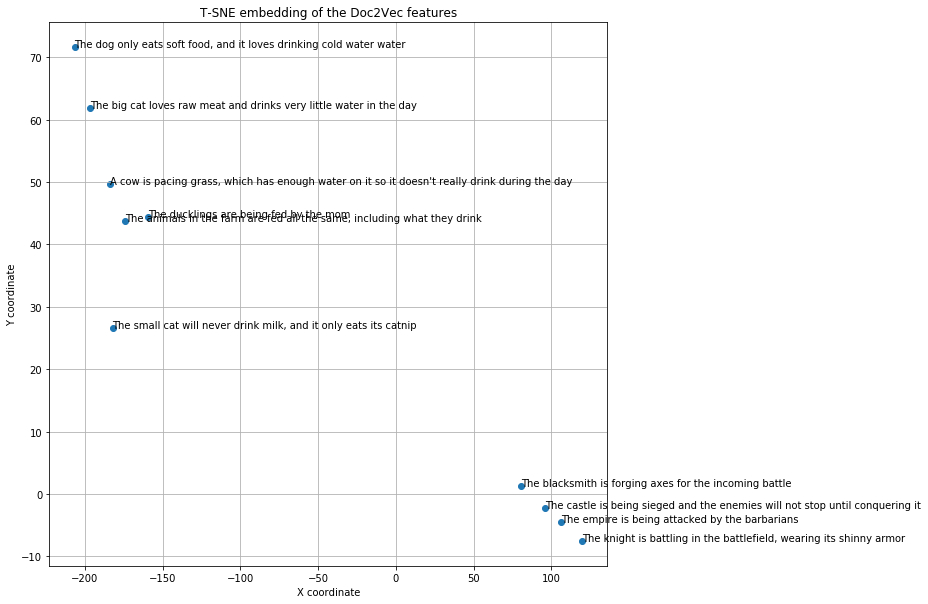

In [8]:
# Embedd in a 2-dimensional space
TSNE_model = TSNE(perplexity=1.5)
TSNE_embeddings = pd.DataFrame(TSNE_model.fit_transform(X=np.array(embeddings.drop('sentence', axis=1))))
TSNE_embeddings['sentence'] = universe_of_sentences

fig, axes = plt.subplots(1,1, figsize=(10, 10))
plt.scatter(TSNE_embeddings[0], TSNE_embeddings[1])
for i, row in TSNE_embeddings.iterrows(): axes.annotate(row['sentence'], xy=(row[0], row[1]), xycoords='data')
plt.title('T-SNE embedding of the Doc2Vec features')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid()


We can see how the "epic-themed" sentences are grouped together. Same happens for the animals that "don't drink", and the same happens for the rest of the animals that have let's say, a regular diet.

### 2.5. The great advance: LSTM cells  and transformers

While Doc2Vec makes use of Neural Networks as part of its components (see [CBOW](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html) and [Skip-gram](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html) models), **most relevant advances in NLP come hand by hand with the development of advanced deep network architectures leveraging cell memory mechanisms such as the LSTM cells**.

#### CONTEXT IS IMPORTANT: RNN's

Text can be seen as time series data in the sense that all previous words are relevant to understand further contents, since they create context. While the RNN architecture (recurrent neural networks) already enable learning from patterns repeated over time (time-series data) by introducing *hidden states* as representation of **previous inputs** they suffer from specific issues relating to the computation of gradients (check out [this article](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9) for a very nice and easy introduction to RNN)

#### LSTM

[LSTM](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714) (or *long short term memory*) is a network architecture that enables a model to capture both recent, syntatically-relevant information as well as previous, topic-relevant information in a balanced fashion. Below is depicted the architecture of an LSTM cell

![lstm cell](images/lstm_cell.PNG)

What is relevant from here is that each cell will have two outputs: the short-term memory (cell specific output) and the long-term memory (which is passed from cell to cell and altered by each cell with their own contribution).

This development has proven massive in order to increase model comprehension ability as part of a wave of advanced NLP models known as transformers.

#### TRANSFORMERS AND RELATED OPEN SOURCE PROJECTS

The biggest NLP players are currently in a race to develop pretrained model architectures able to generalize to the widest range of tasks (measured through comprehensive benchmarks such as [GLUE](https://gluebenchmark.com/)), with relevant advance's such as Google's [BERT](https://arxiv.org/abs/1906.08237) or [XLNet](https://arxiv.org/abs/1906.08237). This, along with the democratization of contents promoted by the open source NLP community (such as the [Hugging Face project](https://github.com/huggingface/transformers)) is making it affordable to adapt these models to pretty much any NLP task through widely supported API's such as PyTorch or TensorFlow.

### 3. Practical example, sentiment analysis for reviews


- Word vectors to play with here: https://fasttext.cc/docs/en/english-vectors.html
- Dataset for trainign sentimental analysis here: https://www.kaggle.com/kazanova/sentiment140



In [9]:
# ! pip install spicy
# ! pip install tqdm
from scipy.spatial.distance import cosine as cosine_distance
from tqdm.auto import tqdm
import io

In [10]:
# Pretrained models from: T. Mikolov, E. Grave, P. Bojanowski, C. Puhrsch, A. Joulin. Advances in Pre-Training Distributed Word Representations
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array([ float(x) for x in tokens[1:] ])
    return data

In [11]:
fasttext = load_vectors("./models/wiki-news-300d-1M.vec")

In [12]:
# fasttext['house']

In [13]:
def analogy(a, b, c, fast_vectors):

    # Words to Vec
    emb_a, emb_b, emb_c = fast_vectors[a.lower()], fast_vectors[b.lower()], fast_vectors[c.lower()]
    
    words = fast_vectors.keys()
    max_cosine_sim = -999              
    best_word = None   
    
    # loop over the universe
    for w in tqdm(words):
        
        # skip the input words
        if w in [a.lower(), b.lower(), c.lower()] :
            continue
        
        # Cosine similarity = 1 - cosine distance
        cosine_sim = 1 - cosine_distance(emb_b-emb_a, fast_vectors[w]-emb_c)

        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
    return best_word

In [14]:
analogy_words = ['spain', 'spanish', 'italy']
print ('{} -> {} // {} -> {}'.format( *analogy_words, analogy(*analogy_words,fasttext)))


spain -> spanish // italy -> italian


In [15]:
analogy_words = ['big', 'bigger', 'small']
print ('{} -> {} // {} -> {}'.format( *analogy_words, analogy(*analogy_words,fasttext)))


big -> bigger // small -> smaller


In [16]:
analogy_words = ['man', 'woman', 'boy']
print ('{} -> {} // {} -> {}'.format( *analogy_words, analogy(*analogy_words,fasttext)))


man -> woman // boy -> girl


In [17]:
analogy_words = ['queen', 'king', 'woman']
print ('{} -> {} // {} -> {}'.format( *analogy_words, analogy(*analogy_words,fasttext)))


queen -> king // woman -> man


# Sentimental Analysis

First we load the emoji package, so we can identify the sentiment of a tweet by an emoji

In [18]:
# !pip install emoji
import emoji

In [19]:
emojify = {
    0: ':face_with_symbols_on_mouth:', 
    4: ':smiling_face_with_smiling_eyes:'
}

In [20]:
# Load tweets dataset
tweets = pd.read_csv('./data/trainingset.csv', encoding = "ISO-8859-1", error_bad_lines=False, header=None)[[0, 5]]
tweets.columns = ['target', 'tweet']
positive_t = tweets[tweets.target == 4]
negative_t = tweets[tweets.target == 0]
train_df = pd.concat([positive_t.head(3000), negative_t.head(3000)])
train_df = train_df.sample(train_df.shape[0])
train_df.sample(10)


,target,tweet
802738,4,"todays diet: 2 packets of chips, 2 apples, lots of maccas, biscuits and sultana cake"
801124,4,ok... headed to bed. tomorrow I open shop for freddy and eddy
1528,0,"ugh, just read on #CNN that they found the Cantu girl's body in a pond near their home. How terr..."
1231,0,@thecoolestout
800713,4,losing time
427,0,@maxime68 @megelder But! I'm useless if I don't sleep It's not fair! I want all the fun as well!!!
802602,4,it was SOOO simple...but i knew i would get it!! *smiles REALLY big* good night!
800297,4,just created this account...looking around
781,0,@andreabakes Oh gee - insomnia sucks Have you tried melatonin?
1186,0,"@jon8737 that just totally made my night, LMAO. They were like screaming at me and I couldn't fo..."


In [21]:
# We generate the universe of sentences from a random sample of the dataset:
universe_of_sentences = train_df.tweet.values

## BoW

In [22]:
# Create the vocabulary object and obtain the bag of word representation
all_sentences = []
for sentence in tqdm(universe_of_sentences):
    w_sentence = [token.text for token in nlp(sentence) if not token.is_punct]
    all_sentences.append(w_sentence)
dct = Dictionary(all_sentences)

In [23]:
records = []
record = dict.fromkeys(list(dct.values()), 0)
for sentence in tqdm(universe_of_sentences):
    record_1 = record.copy()
    record_1.update({dct[k]: v for k,v in dct.doc2bow([token.text for token in nlp(sentence) if not token.is_punct])})
    records.append(record_1)
bow_df = pd.DataFrame(records)


In [24]:
bow_df['__target__'] = train_df.target.values

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier(max_depth=5, random_state=24)
X = bow_df[bow_df.columns[:-1]].values
y = bow_df.__target__.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
clf.fit(X_train, y_train)
print(f"Accuray of random forest classifier: {clf.score(X_test, y_test)}")

Accuray of random forest classifier: 0.6666666666666666


In [51]:
to_predict = input("Introduce a tweet: ")
record_1 = record.copy()
record_1.update({dct[k]: v for k,v in dct.doc2bow([token.text for token in nlp(to_predict) if not token.is_punct])})
res = clf.predict(np.array(list(record_1.values())).reshape(1, -1))[0]
print(emoji.emojize(f"Your tweet was: {emojify[res]}"))

Introduce a tweet: I'm super angry, you are an asshole
Your tweet was: 😊


## TF-IDF

In [28]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Some example stopwords:', list(stopwords)[20:25])

# Modify the universe of sentences by removing stopwords and lemmatizing
universe_of_sentences_mod = [[token.lemma_.lower() for token in nlp(sentence) 
                              if token not in stopwords and not token.is_punct] 
                             for sentence in universe_of_sentences]

# Train the TFIDF model over our corpus
TFIDF_model = TfidfModel([dct.doc2bow(sentence) for sentence in universe_of_sentences_mod])

# Get the representation for the first sentence in the universe
record = {dct[k]: 0 for k,v in dct.items()}
record.update({dct[k]:v for k,v in TFIDF_model[dct.doc2bow(universe_of_sentences_mod[0])]})
pd.DataFrame([record])

Some example stopwords: ['say', 'next', 'take', 'eight', 'thereafter']


,Spring,at,break,but,celebrate,here,is,last,no,one,to,,4,B,Got,Grabbing,Hope,I,Long,Zzs,a,as,bit,blankey,bloodletting,can,catch,chair,day,few,in,just,off,result,ta,the,then,up,,M25,Sodding,http://twitpic.com/2y3y0,@Alliana07,actually,any,believe,did,happened,it,make,me,n't,refuse,sense,suicide,that,thing,what,'s,@oedesigner,and,certainly,do,for,got,great,help,know,link,lot,not,sure,'m,Amazing,It,genius,i,still,worked,@DeiondraSanders,always,late,morning,person,was,wish,@KimKardashian,Apprentice,Khloe,fired,from,rt,'ve,@KavisMusings,But,Interesting,Two,amp,are,ca,horse,horses,more,mules,nt,race,read,smarter,than,work,46,Why,acknowledge,followers,have,none,of,whom,This,cold,expensive,internet,really,river,wye,hurts,my,paronychia,,nobody,talking,Well,sucked,all,hope,lost,sigh,3,5,am,gt,oatmeal,soup,veg,ASBA,Is,pissed,radio,station,there,@brainiacmathew,m,on,spring,time,@getvisible,ambulance,chasing,journalists,lawyers,reckoning,with,'d,@sian_the_mouse,anything,be,duck,if,lol,want,watching,yay,@KateriH,How,My,TJ,dinner,down,freezer,melted,tonight,BBC,drama,get,like,relax,train,you,@dwsmillionthhug,Just,giving,hard,made,life,loving,family,kids,movie,precious,@Poohpot,ate,lmao,poohpot,sorry,@cornbreadturner,enjoy,gotmilk,milk,@__dev_dsp,Hrm,back,holding,posts,sound,two,your,an,bread,calling,does,dollar,early,going,nicely,night,over,store,taxes,toast,wheat,'re,@vindiekins,Aww,MTP,RP,Torn,avatars,hoping,input,leaving,personality,thread,added,iPhone,new,tweetie,Twitter,feeling,'ll,@BrokenRoses,...,frogs,http://tinyurl.com/cxe8w7,@headtotail,RED,buhok,hihi,http://plurk.com/p/n07qu,qku,desert,ocean,@katsun,Live365,optimistic,@LauralKGW,Kid,chopsticks,flies,oriental,@riax3x,Jennifer,lifes,Dansu,Hip,Ne,adult,hippidy,hop,hoppers,isolation-,ne,shimasho,@HibaNick,wudnt,Lukas,Lunch,aiden,taylorians.com,@berofx,@ilovepie,chapped,lips,http://bit.ly/qZuUY,@tpaw,wooo,endured,everythin,tomory,@axisportals,adulthood,scowls,@Luke_Stephens,@hopeinhell,@iamjazzyfizzle,@iamlilnicki,@SarahLSharp,Balamurugan,longterm,twitterpeeps,@jilly_t,baaack,escapades,MIA,codez,lt;33,they've,@annabellee,potato,@TheoryOfMind,@woppygook,OMNIAAAA,crackberrryyy,depart,@nassyusof,primrose,@huntermoore,Brie,Cabernet,Date,Hamilton&quot,Tad,flashed,gawwd,quot;Win,istanbul,roads,hatch,wayyy,GPRS,document,tables,Noise,http://www.last.fm/music/Noise+Boy,predictions,triple,wrestlemania,@glenzgolfvi,@januarycrimson,Muahaha,Thankfully,annoys,xtra,debbs,webbs,Hillsong,Death,@wisequeen,Plenty,Burswood,poster,unfortunatly,@Sirrah21,froofroo,Shihan,@pattidigh,SIETAR,boundaries,buzzing,manual,@StephenChallens,XX,@Tiandrance,@PartyWater,depend,@nikhilnarayanan,tvc,Rescheduling,circumstances,@innocent42nite,chipped,stapling,lumea,toat,thaaaaang,www.toutlemondesurcf.blogspot.com,drivin,@lammb,1983,Papal,geopolitical,trench,typed,warfare,wargames,@xambix,@chauncey78,Answer,Branding,Creating,Files,Impressive,Installation,OEM,Rather,Times,@BatManYNG,Blood,Sand,Wutcha,copped,ps3,http://twurl.nl/ibz2wb,@kitty_stiletto,@nashipear,4:15,CO,@mollydotcom,Molly,Fancast,@LizMyers,impressions,@wilshipley,DL2,Dutch,incomplete,localization,truncations,Blackberry,Bold,Kingston,gb,microsd,route,@direbonappetit,Hamlet,fussed,Managed,bounds,dived,suuuper,"100,000",soinma,herrr,requested,@courtneylou,Hit,belief,beyond,textin,@leslie_nassar,Coles,Important,DK,Halls,PuG,Stone,eveything,ith,lvl80,whent,@ItsDawns,@rmilana,Danish,@johannacherry,@griffmiester,exchanging,useless,@trentvanegas,Trent,plenty,14th,15th,Maddie,eatser,@tothepc,Visual,Vocabulary,dictionary,http://www.weboword.com,@ariherzog,Ari,Hemel,Hempstead,eyebrows,waxed,Headache,Pleeeease,Rossi,torture,tweetin,Stephen,@kenjbarnes1,@LittleYellowJen,nawwww,FUCKKKKKKKKKKKKK,IDs,@mkaigwa,derailer,kwaito,@KateKendall,Kate
0,0,0.180806,0.317883,0.166212,0.467983,0.530059,0,0.273434,0.217789,0.223658,0.080557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
records = []
record = dict.fromkeys(list(dct.values()), 0)
for sentence in tqdm(universe_of_sentences_mod):
    record_1 = record.copy()
    record_1.update({dct[k]:v for k,v in TFIDF_model[dct.doc2bow(sentence)]})
    records.append(record_1)
tfidf_df = pd.DataFrame(records)

In [30]:
tfidf_df = pd.DataFrame(records)

In [31]:
tfidf_df['__target__'] = train_df.target.values

In [52]:
clf_tf = RandomForestClassifier(max_depth=5, random_state=24)
X = tfidf_df[tfidf_df.columns[:-1]].values
y = tfidf_df.__target__.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
clf_tf.fit(X_train, y_train)
print(f"Accuray of random forest classifier: {clf_tf.score(X_test, y_test)}")

Accuray of random forest classifier: 0.6606666666666666


In [53]:
to_predict = input("Introduce a tweet: ")
to_predict = [token.lemma_.lower() for token in nlp(to_predict) if token not in stopwords and not token.is_punct]
record_1 = record.copy()
record_1.update({dct[k]:v for k,v in TFIDF_model[dct.doc2bow(to_predict)]})
res = clf_tf.predict(np.array(list(record_1.values())).reshape(1, -1))[0]
print(emoji.emojize(f"Your tweet was: {emojify[res]}"))

Introduce a tweet: I'm super angry, you are an asshole
Your tweet was: 😊


Doc2Vec Embeddings

In [54]:
# Get the vector representation of our sentences
embeddings = pd.DataFrame([Doc2Vec_model.infer_vector([token.lemma_.lower() for token in nlp(sentence) if token not in stopwords and not token.is_punct],
                                                      alpha=0.05, steps=1) for sentence in tqdm(universe_of_sentences)], 
                          columns=['Doc2Vec_{}'.format(x) for x in range(300)])
embeddings['sentence'] = universe_of_sentences
embeddings = embeddings[['sentence']+list(embeddings.columns[:-1])]
embeddings.loc[0]


sentence       Spring break is here at last, but no one is here to celebrate 
Doc2Vec_0                                                           0.0209596
Doc2Vec_1                                                          -0.0139722
Doc2Vec_2                                                          -0.0105966
Doc2Vec_3                                                           0.0240863
                                            ...                              
Doc2Vec_295                                                         -0.014658
Doc2Vec_296                                                         0.0275127
Doc2Vec_297                                                         0.0509649
Doc2Vec_298                                                         0.0258042
Doc2Vec_299                                                         0.0140908
Name: 0, Length: 301, dtype: object

In [55]:
embeddings.head()

,sentence,Doc2Vec_0,Doc2Vec_1,Doc2Vec_2,Doc2Vec_3,Doc2Vec_4,Doc2Vec_5,Doc2Vec_6,Doc2Vec_7,Doc2Vec_8,Doc2Vec_9,Doc2Vec_10,Doc2Vec_11,Doc2Vec_12,Doc2Vec_13,Doc2Vec_14,Doc2Vec_15,Doc2Vec_16,Doc2Vec_17,Doc2Vec_18,Doc2Vec_19,Doc2Vec_20,Doc2Vec_21,Doc2Vec_22,Doc2Vec_23,Doc2Vec_24,Doc2Vec_25,Doc2Vec_26,Doc2Vec_27,Doc2Vec_28,Doc2Vec_29,Doc2Vec_30,Doc2Vec_31,Doc2Vec_32,Doc2Vec_33,Doc2Vec_34,Doc2Vec_35,Doc2Vec_36,Doc2Vec_37,Doc2Vec_38,Doc2Vec_39,Doc2Vec_40,Doc2Vec_41,Doc2Vec_42,Doc2Vec_43,Doc2Vec_44,Doc2Vec_45,Doc2Vec_46,Doc2Vec_47,Doc2Vec_48,Doc2Vec_49,Doc2Vec_50,Doc2Vec_51,Doc2Vec_52,Doc2Vec_53,Doc2Vec_54,Doc2Vec_55,Doc2Vec_56,Doc2Vec_57,Doc2Vec_58,Doc2Vec_59,Doc2Vec_60,Doc2Vec_61,Doc2Vec_62,Doc2Vec_63,Doc2Vec_64,Doc2Vec_65,Doc2Vec_66,Doc2Vec_67,Doc2Vec_68,Doc2Vec_69,Doc2Vec_70,Doc2Vec_71,Doc2Vec_72,Doc2Vec_73,Doc2Vec_74,Doc2Vec_75,Doc2Vec_76,Doc2Vec_77,Doc2Vec_78,Doc2Vec_79,Doc2Vec_80,Doc2Vec_81,Doc2Vec_82,Doc2Vec_83,Doc2Vec_84,Doc2Vec_85,Doc2Vec_86,Doc2Vec_87,Doc2Vec_88,Doc2Vec_89,Doc2Vec_90,Doc2Vec_91,Doc2Vec_92,Doc2Vec_93,Doc2Vec_94,Doc2Vec_95,Doc2Vec_96,Doc2Vec_97,Doc2Vec_98,Doc2Vec_99,Doc2Vec_100,Doc2Vec_101,Doc2Vec_102,Doc2Vec_103,Doc2Vec_104,Doc2Vec_105,Doc2Vec_106,Doc2Vec_107,Doc2Vec_108,Doc2Vec_109,Doc2Vec_110,Doc2Vec_111,Doc2Vec_112,Doc2Vec_113,Doc2Vec_114,Doc2Vec_115,Doc2Vec_116,Doc2Vec_117,Doc2Vec_118,Doc2Vec_119,Doc2Vec_120,Doc2Vec_121,Doc2Vec_122,Doc2Vec_123,Doc2Vec_124,Doc2Vec_125,Doc2Vec_126,Doc2Vec_127,Doc2Vec_128,Doc2Vec_129,Doc2Vec_130,Doc2Vec_131,Doc2Vec_132,Doc2Vec_133,Doc2Vec_134,Doc2Vec_135,Doc2Vec_136,Doc2Vec_137,Doc2Vec_138,Doc2Vec_139,Doc2Vec_140,Doc2Vec_141,Doc2Vec_142,Doc2Vec_143,Doc2Vec_144,Doc2Vec_145,Doc2Vec_146,Doc2Vec_147,Doc2Vec_148,Doc2Vec_149,Doc2Vec_150,Doc2Vec_151,Doc2Vec_152,Doc2Vec_153,Doc2Vec_154,Doc2Vec_155,Doc2Vec_156,Doc2Vec_157,Doc2Vec_158,Doc2Vec_159,Doc2Vec_160,Doc2Vec_161,Doc2Vec_162,Doc2Vec_163,Doc2Vec_164,Doc2Vec_165,Doc2Vec_166,Doc2Vec_167,Doc2Vec_168,Doc2Vec_169,Doc2Vec_170,Doc2Vec_171,Doc2Vec_172,Doc2Vec_173,Doc2Vec_174,Doc2Vec_175,Doc2Vec_176,Doc2Vec_177,Doc2Vec_178,Doc2Vec_179,Doc2Vec_180,Doc2Vec_181,Doc2Vec_182,Doc2Vec_183,Doc2Vec_184,Doc2Vec_185,Doc2Vec_186,Doc2Vec_187,Doc2Vec_188,Doc2Vec_189,Doc2Vec_190,Doc2Vec_191,Doc2Vec_192,Doc2Vec_193,Doc2Vec_194,Doc2Vec_195,Doc2Vec_196,Doc2Vec_197,Doc2Vec_198,Doc2Vec_199,Doc2Vec_200,Doc2Vec_201,Doc2Vec_202,Doc2Vec_203,Doc2Vec_204,Doc2Vec_205,Doc2Vec_206,Doc2Vec_207,Doc2Vec_208,Doc2Vec_209,Doc2Vec_210,Doc2Vec_211,Doc2Vec_212,Doc2Vec_213,Doc2Vec_214,Doc2Vec_215,Doc2Vec_216,Doc2Vec_217,Doc2Vec_218,Doc2Vec_219,Doc2Vec_220,Doc2Vec_221,Doc2Vec_222,Doc2Vec_223,Doc2Vec_224,Doc2Vec_225,Doc2Vec_226,Doc2Vec_227,Doc2Vec_228,Doc2Vec_229,Doc2Vec_230,Doc2Vec_231,Doc2Vec_232,Doc2Vec_233,Doc2Vec_234,Doc2Vec_235,Doc2Vec_236,Doc2Vec_237,Doc2Vec_238,Doc2Vec_239,Doc2Vec_240,Doc2Vec_241,Doc2Vec_242,Doc2Vec_243,Doc2Vec_244,Doc2Vec_245,Doc2Vec_246,Doc2Vec_247,Doc2Vec_248,Doc2Vec_249,Doc2Vec_250,Doc2Vec_251,Doc2Vec_252,Doc2Vec_253,Doc2Vec_254,Doc2Vec_255,Doc2Vec_256,Doc2Vec_257,Doc2Vec_258,Doc2Vec_259,Doc2Vec_260,Doc2Vec_261,Doc2Vec_262,Doc2Vec_263,Doc2Vec_264,Doc2Vec_265,Doc2Vec_266,Doc2Vec_267,Doc2Vec_268,Doc2Vec_269,Doc2Vec_270,Doc2Vec_271,Doc2Vec_272,Doc2Vec_273,Doc2Vec_274,Doc2Vec_275,Doc2Vec_276,Doc2Vec_277,Doc2Vec_278,Doc2Vec_279,Doc2Vec_280,Doc2Vec_281,Doc2Vec_282,Doc2Vec_283,Doc2Vec_284,Doc2Vec_285,Doc2Vec_286,Doc2Vec_287,Doc2Vec_288,Doc2Vec_289,Doc2Vec_290,Doc2Vec_291,Doc2Vec_292,Doc2Vec_293,Doc2Vec_294,Doc2Vec_295,Doc2Vec_296,Doc2Vec_297,Doc2Vec_298,Doc2Vec_299
0,"Spring break is here at last, but no one is here to celebrate",0.020960,-0.013972,-0.010597,0.024086,-0.010290,0.087410,-0.081288,0.000914,-0.002918,-0.034598,-0.026232,-0.024129,-0.098662,-0.069855,-0.105313,0.150859,-0.043378,0.008108,-0.058702,-0.064807,-0.052333,-0.105511,0.093499,0.014833,0.057389,-0.041517,-0.023679,0.014744,-0.044678,0.024728,-0.066689,0.004418,0.011585,-0.011496,0.001563,0.060156,-0.095444,-0.091961,-0.029515,-0.044929,0.003837,-0.069175,-0.000532,-0.022698,0.002402,-

In [56]:
doc_df = embeddings[embeddings.columns[1:]]
doc_df['__target__'] = train_df.target.values

In [57]:
clf_doc = RandomForestClassifier(max_depth=5, random_state=24)
X = doc_df[doc_df.columns[:-1]].values
y = doc_df.__target__.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
clf_doc.fit(X_train, y_train)
print(f"Accuray of random forest classifier: {clf_doc.score(X_test, y_test)}")

Accuray of random forest classifier: 0.6346666666666667


In [58]:
to_predict = input("Introduce a tweet: ")
tp = Doc2Vec_model.infer_vector([token.lemma_.lower() for token in nlp(to_predict) if token not in stopwords and not token.is_punct])
res = clf_doc.predict(tp.reshape(1, -1))[0]
print(emoji.emojize(f"Your tweet was: {emojify[res]}"))

Introduce a tweet: I'm super angry, you are an asshole
Your tweet was: 🤬
